In [3]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle 
import bammm.bammm as mm
from scipy.stats import zscore as zscore_sc
import statsmodels.api as sm
from scipy.stats import t


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))


##### VERY IMPORTANT ####

df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

tdf = df.loc[df["sess_str"]=="sess0",:]
tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]


#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
##df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]

##### VERY IMPORTANT ####

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'ProbabilityEstims',
           'q7_worry_econ_impact': 'EconWorry',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGroup',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaValence',
           'q7_period_rel_danger': 'CurrentThreat',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'q6_houshold_membs': "HouseholdMembers",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }

df=df.rename(columns=mapdict)

# Create column with appropriate dates
df["Session"] = df["session"]
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

## transform and generate some variables (to be moved to preprocessing)

vars = [
        # core things interested in 
        "Deaths",
        "Cases",
        "CurrentThreat",
        "ProbabilityEstims",
        "InforSeek",
        "AvoidBeh",
        ]

trait_factor_names = ["TF1_CognAnxDepr",  "TF2_PhysiolAnx","TF3_NegativeAffect" ]
tfs = ["TF"+str(x) for x in range(1,4)]

corr_type = "spearman" # used in all analyses



/data/drive/postdoc/Project4_covid


Number of rows removed: 191


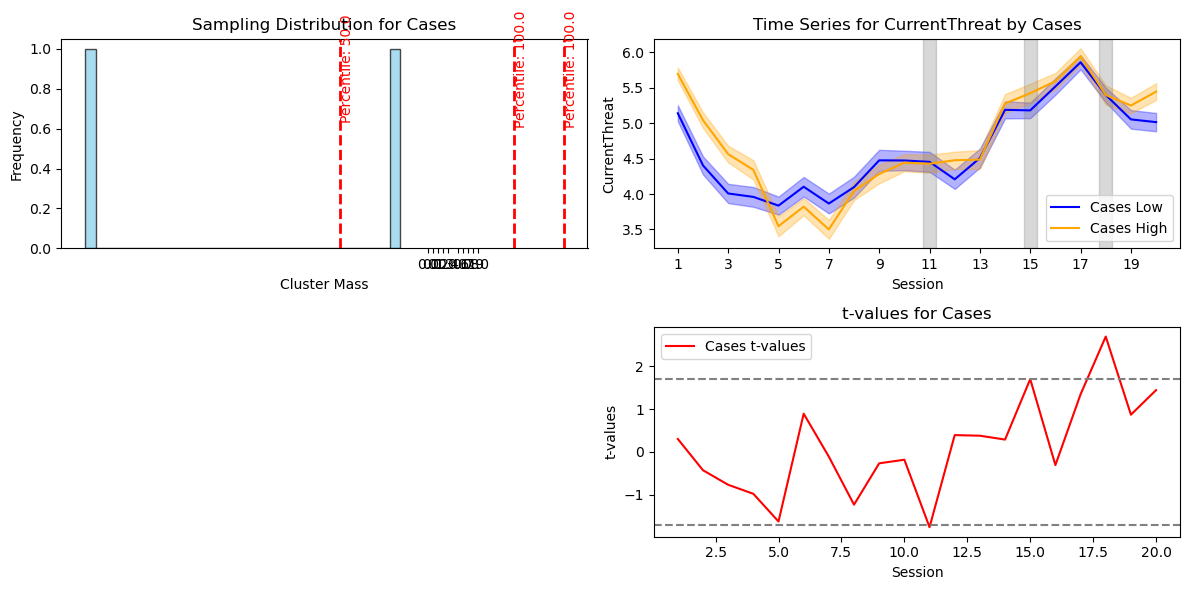

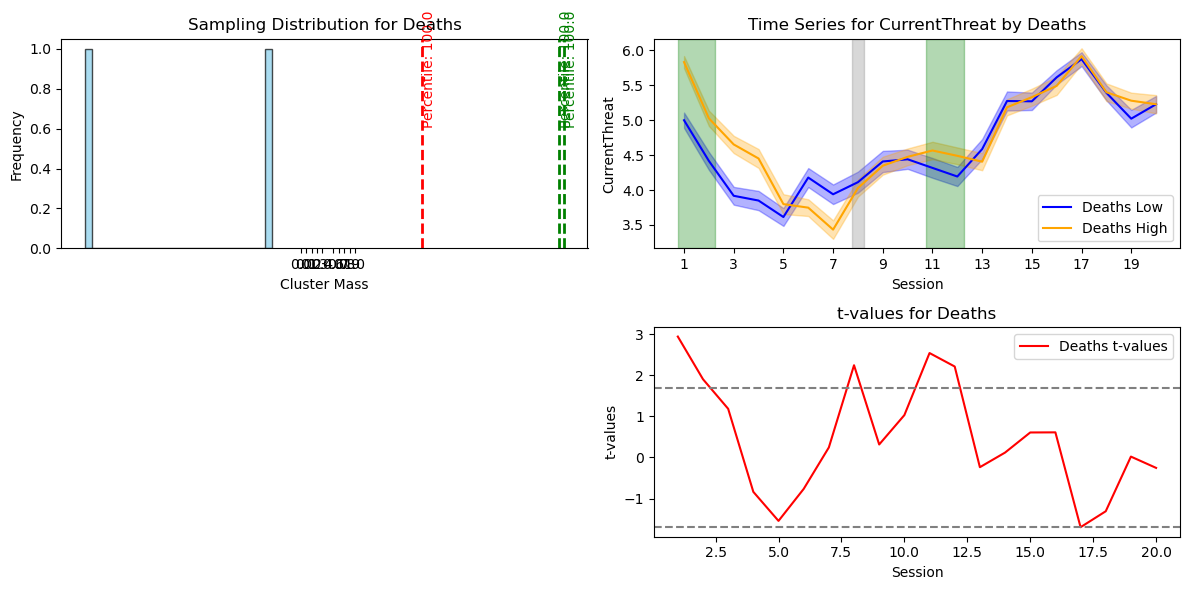

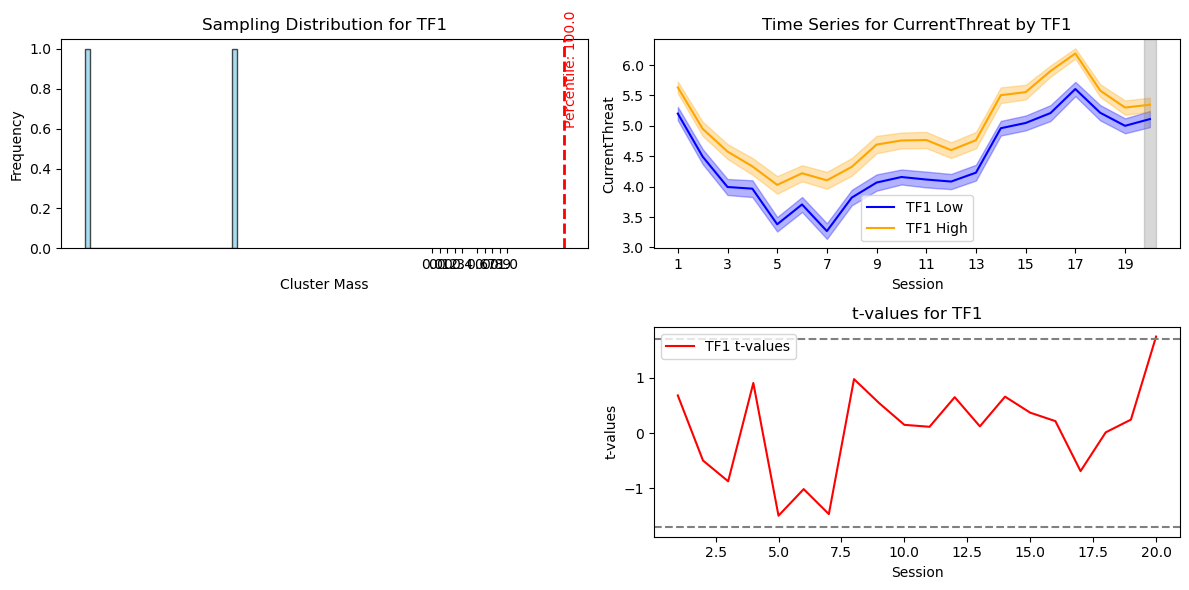

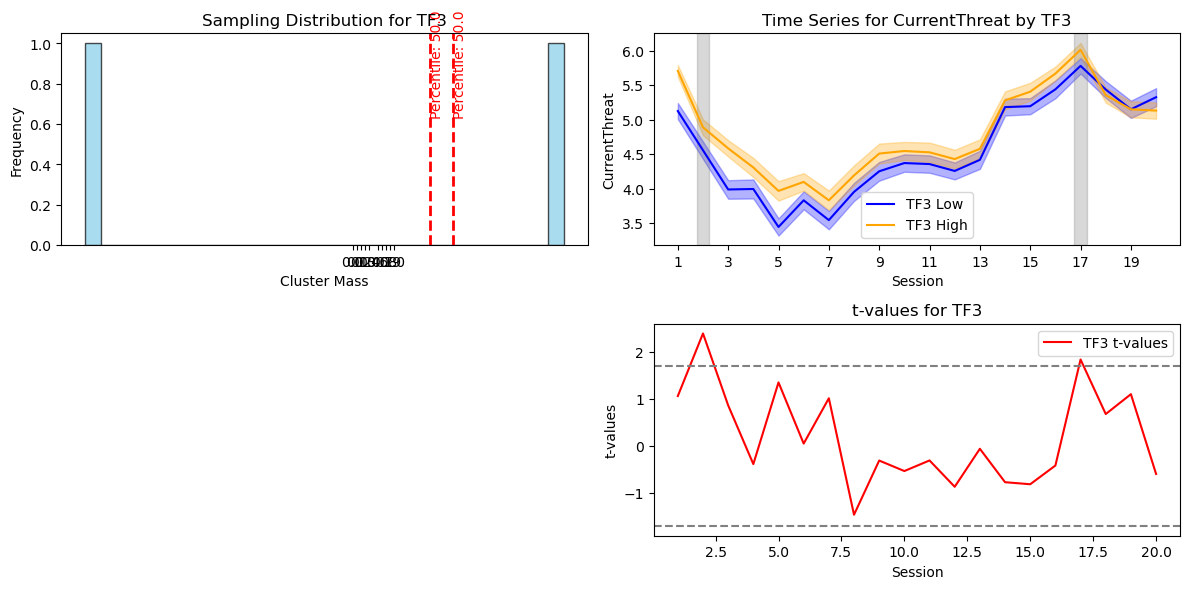

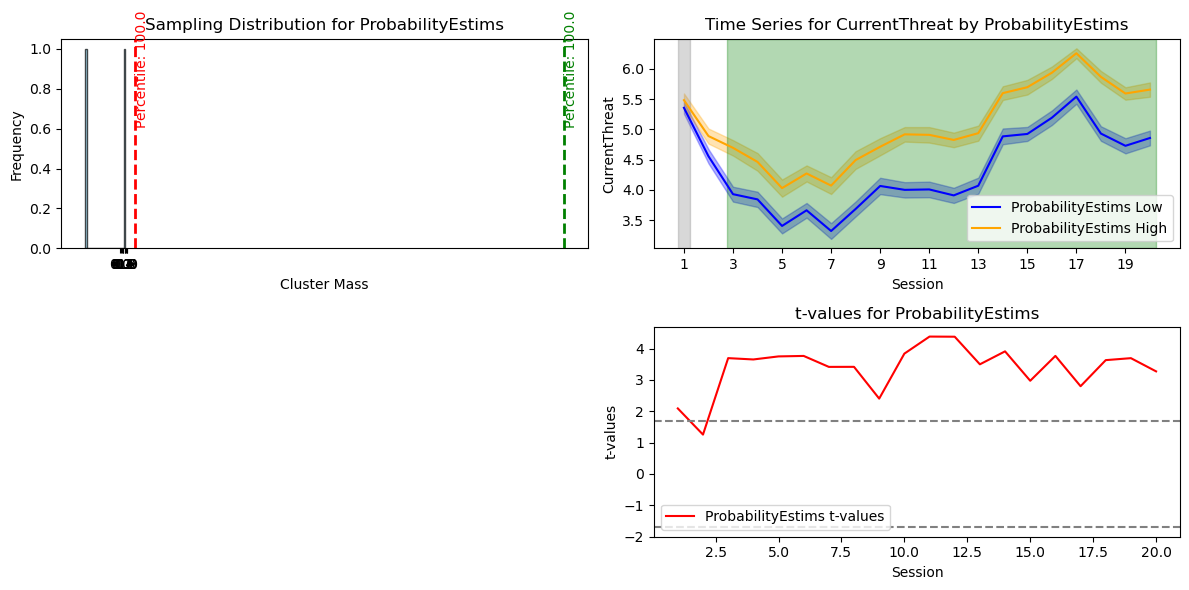

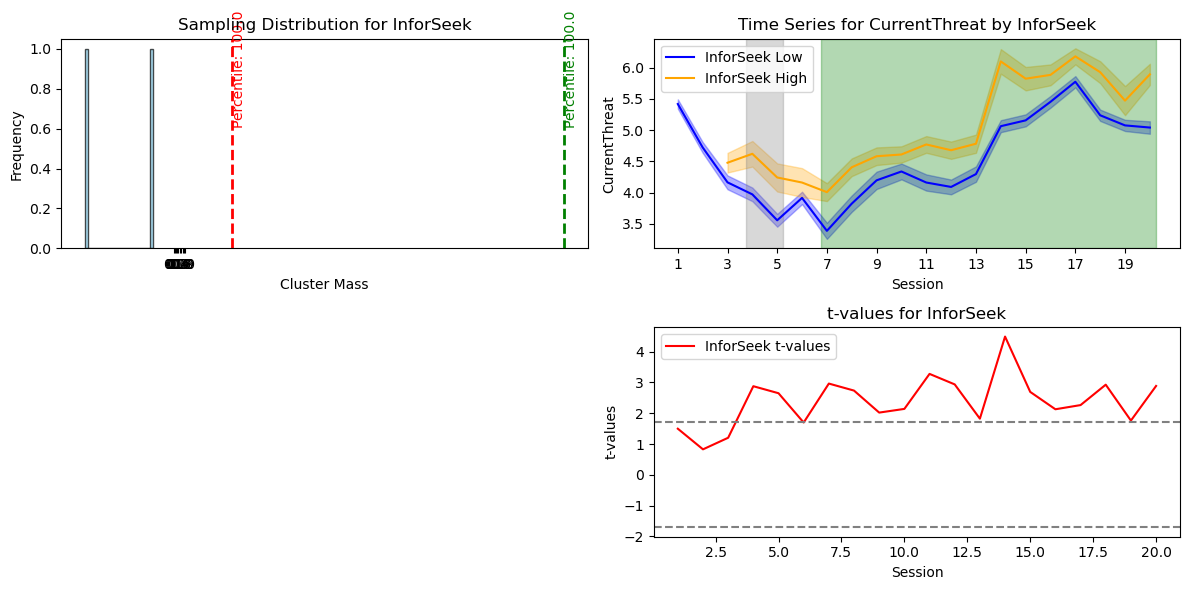

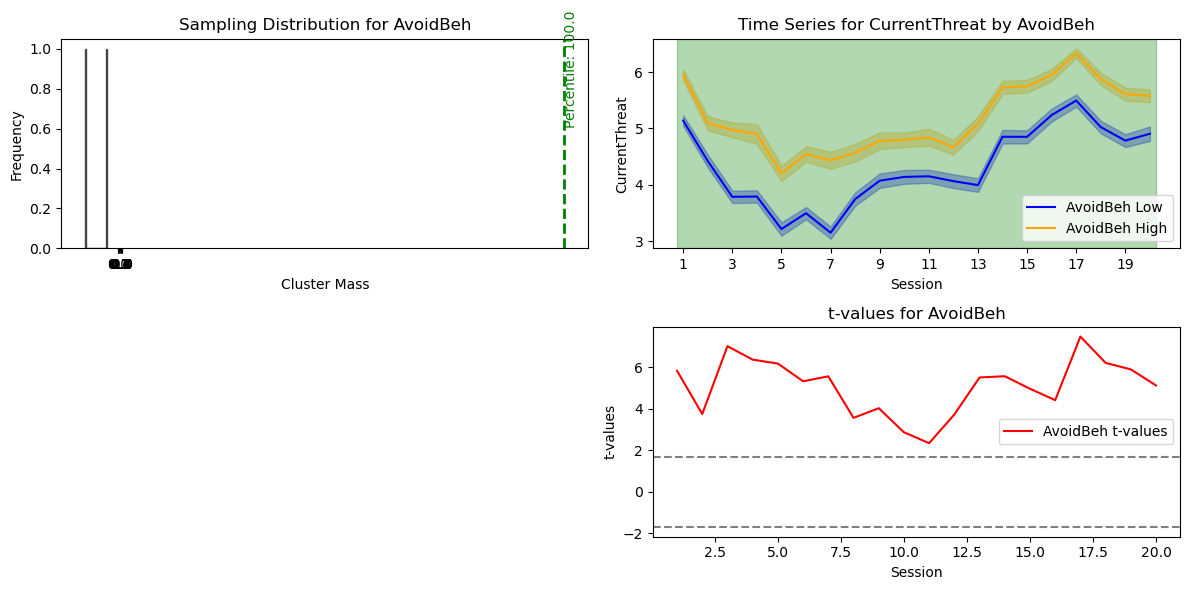

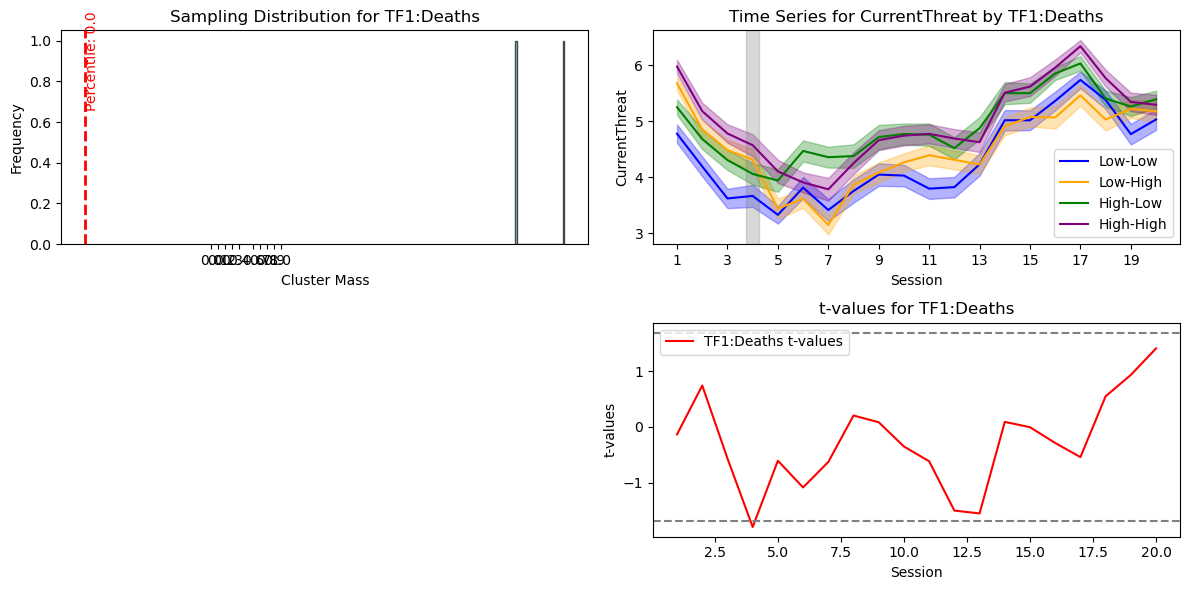

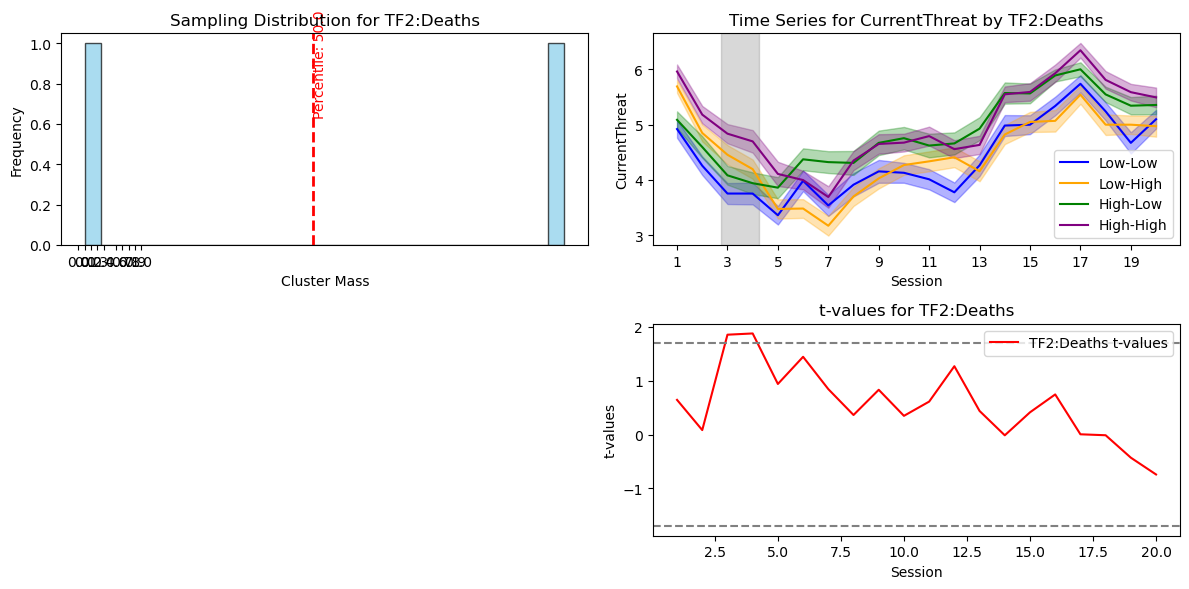

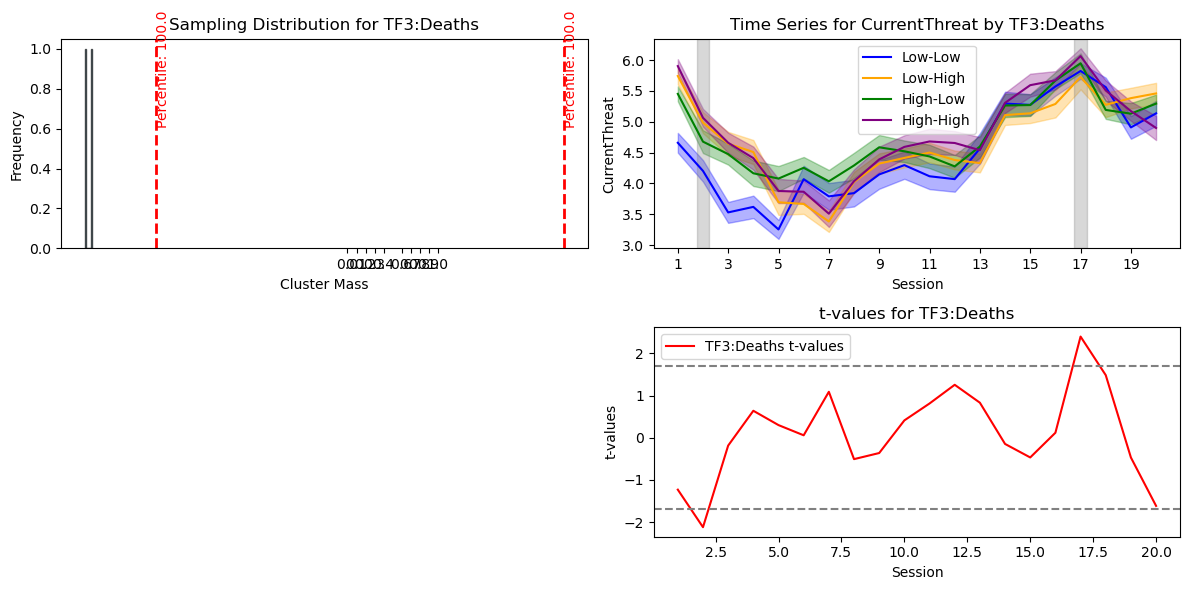

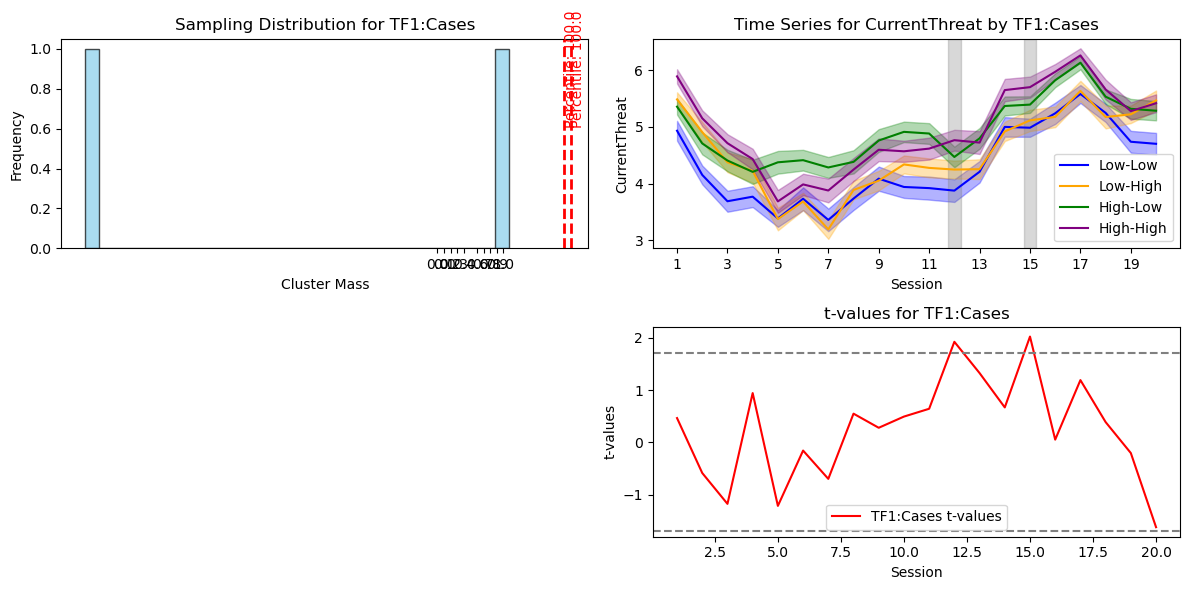

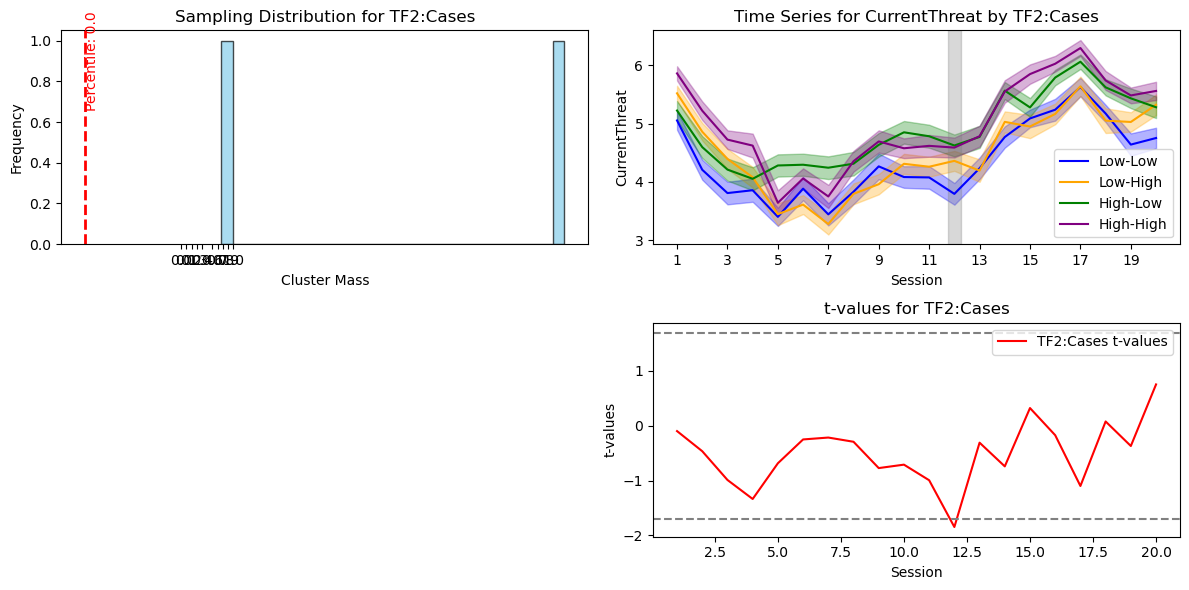

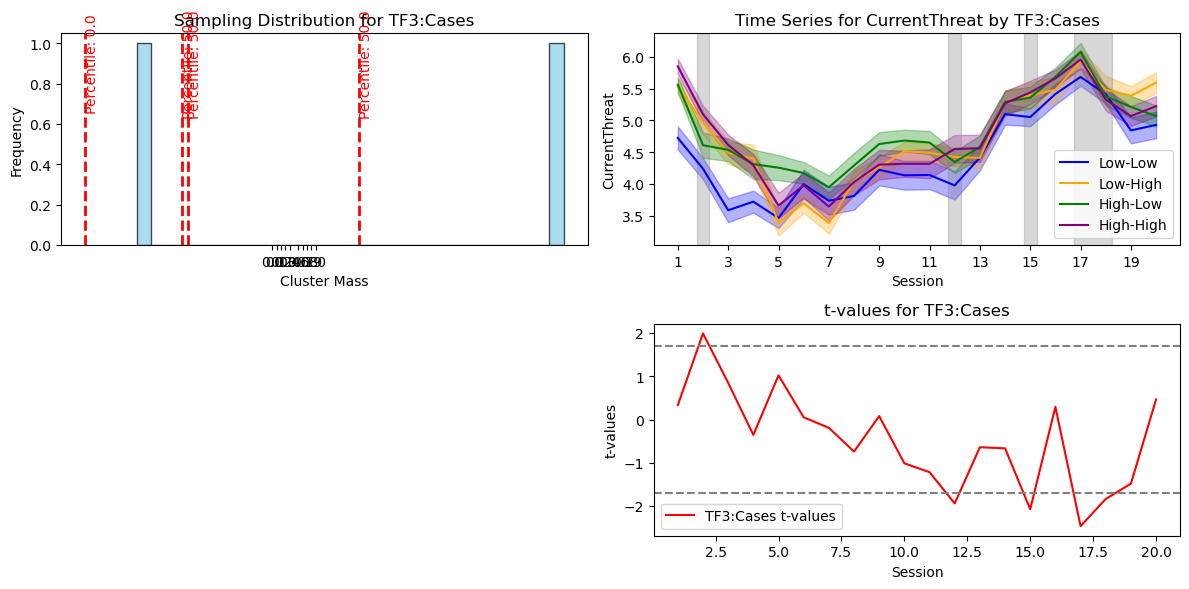

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import percentileofscore
from scipy.stats import zscore


# Placeholder for your dataset
# df = pd.read_csv('your_data.csv')

# List of required columns
required_columns = [
    "PROLIFICID", "Session", "CurrentThreat", "ProbabilityEstims", "InforSeek", "AvoidBeh", 
    "TF1", "TF2", "TF3", "Deaths", "Cases"
]

# Select only the necessary columns
df_selected = df[required_columns]

# Print the initial number of rows
initial_rows = len(df_selected)

# Remove rows with any missing values
df_cleaned = df_selected.dropna()

# Print the number of rows removed
removed_rows = initial_rows - len(df_cleaned)
print(f"Number of rows removed: {removed_rows}")

# Function to perform regression and get t-values for each session
def regression_t_values_per_session(data, dependent_var):
    predictors = ["Cases", "Deaths", "TF1", "TF2", "TF3"]
    
    # Add other dependent variables as fixed effects
    fixed_effects = ["CurrentThreat", "ProbabilityEstims", "InforSeek", "AvoidBeh"]
    fixed_effects.remove(dependent_var)  # Remove the current dependent variable
    
    predictors += fixed_effects
    
    # Creating interaction terms
    data["TF1:Deaths"] = data["TF1"] * data["Deaths"]
    data["TF2:Deaths"] = data["TF2"] * data["Deaths"]
    data["TF3:Deaths"] = data["TF3"] * data["Deaths"]
    data["TF1:Cases"] = data["TF1"] * data["Cases"]
    data["TF2:Cases"] = data["TF2"] * data["Cases"]
    data["TF3:Cases"] = data["TF3"] * data["Cases"]
    
    interaction_terms = ["TF1:Deaths", "TF2:Deaths", "TF3:Deaths", 
                         "TF1:Cases", "TF2:Cases", "TF3:Cases"]
    
    predictors += interaction_terms
    
    sessions = data['Session'].unique()
    effect_names = predictors
    
    b_values = {effect: [] for effect in effect_names}
    t_values = {effect: [] for effect in effect_names}
    
    for session in sessions:
        session_data = data[data['Session'] == session]
        X = session_data[predictors]
        X = X.apply(zscore)
        y = session_data[dependent_var]

        
        if X.isna().any().any() or y.isna().any():
            print(f"NaNs found in session {session}")
            continue

        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        
        for effect in effect_names:
            t_values[effect].append((session, model.tvalues[effect]))
            b_values[effect].append((session, model.params[effect]))
    
    return t_values, b_values

# Function to identify clusters and their masses, along with start and end sessions
def identify_clusters(t_values, threshold=2.3):
    clusters = []
    current_cluster = []
    for (session, t_value) in t_values:
        if abs(t_value) > threshold:
            current_cluster.append((session, t_value))
        else:
            if current_cluster:
                clusters.append(current_cluster)
                current_cluster = []
    if current_cluster:
        clusters.append(current_cluster)
    
    cluster_details = [{
        #"Cluster Mass": sum(np.abs([t_value for _, t_value in cluster])),
        "Cluster Mass": sum([t_value for _, t_value in cluster]),
        "Start Session": cluster[0][0],
        "End Session": cluster[-1][0]
    } for cluster in clusters]
    
    return cluster_details

# Function to perform the cluster-based permutation test
def cluster_based_permutation_test(df, dependent_var, n_permutations=50, threshold=2.3):
    # Get the actual t-values per session
    actual_t_values, betas = regression_t_values_per_session(df, dependent_var)
    
    results = []
    
    for effect, t_values in actual_t_values.items():
        actual_clusters = identify_clusters(t_values, threshold)
        
        # Permutation tests
        permuted_cluster_masses = []
        for _ in range(n_permutations):
            shuffled_df = df.copy()
            for column in shuffled_df.columns:
                if column not in ["PROLIFICID", "Session"]:
                    shuffled_df[column] = np.random.permutation(shuffled_df[column])
            
            permuted_t_values, _ = regression_t_values_per_session(shuffled_df, dependent_var)
            permuted_clusters = identify_clusters(permuted_t_values[effect], threshold=0)
            permuted_cluster_masses.extend([cluster["Cluster Mass"] for cluster in permuted_clusters])
        
        for cluster in actual_clusters:
            cluster_mass = cluster["Cluster Mass"]
            percentile = percentileofscore(permuted_cluster_masses, cluster_mass)
            p_value = np.sum((np.abs(np.array(permuted_cluster_masses)) >= np.abs(cluster_mass)) ) / (n_permutations)
            results.append({
                "Effect": effect,
                "Cluster Mass": cluster_mass,
                "Start Session": cluster["Start Session"],
                "End Session": cluster["End Session"],
                "P-value": p_value,
                "Percentile": percentile,
                "Permuted Cluster Masses": permuted_cluster_masses
            })
    
    return pd.DataFrame(results), actual_t_values

def sem(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))
import ast
# Function to plot the sampling distribution and time-series
def plot_sampling_distribution_and_timeseries(results_df, df, dependent_var, tvals):
    effects = results_df['Effect'].unique()
    
    for effect in effects:
        effect_data = results_df[results_df['Effect'] == effect]
        #permuted_cluster_masses = ast.literal_eval(effect_data.iloc[0]['Permuted Cluster Masses'])
        permuted_cluster_masses = effect_data.iloc[0]['Permuted Cluster Masses']
        

        #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 2]})
        fig, ((ax1, ax2), (empty_ax, ax3)) = plt.subplots(2, 2, figsize=(12, 6), 
                                                          gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
        
        # Remove the empty axis
        fig.delaxes(empty_ax)

        
        # Plot the histogram of the sampling distribution
        ax1.hist(permuted_cluster_masses, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Plot the true effects
        for idx, row in effect_data.iterrows():
            cluster_mass = row['Cluster Mass']
            percentile = row['Percentile']
            p_value = row['P-value']
            
            color = 'green' if p_value < 0.05 else 'red'
            ax1.axvline(x=cluster_mass, color=color, linestyle='--', linewidth=2)
            ax1.text(cluster_mass, plt.ylim()[1]*0.9, f'Percentile: {percentile:.1f}', 
                     rotation=90, verticalalignment='center', color=color)
        
        ax1.set_title('Sampling Distribution for '+effect)
        ax1.set_xlabel('Cluster Mass')
        ax1.set_ylabel('Frequency')
        
        # Set relevant x-axis labels for histogram
        xticks = plt.gca().get_xticks()
        step = max(1, len(xticks) // 10)
        new_xticks = np.linspace(min(xticks), max(xticks), num=10)
        ax1.set_xticks(np.round(new_xticks, 1))
        
        
        if ":" not in effect:
            variable = effect
            session_medians = df.groupby('Session')[variable].median()
            df['Session_Median'] = df['Session'].map(session_medians)
            lower_group = df[df[variable] <= df['Session_Median']]
            upper_group = df[df[variable] > df['Session_Median']]
            
            lower_mean = lower_group.groupby('Session')[dependent_var].mean()
            upper_mean = upper_group.groupby('Session')[dependent_var].mean()
            lower_sem = lower_group.groupby('Session')[dependent_var].apply(sem)
            upper_sem = upper_group.groupby('Session')[dependent_var].apply(sem)
            
            ax2.plot(lower_mean.index, lower_mean, label=f'{variable} Low', color='blue')
            ax2.fill_between(lower_mean.index, lower_mean - lower_sem, lower_mean + lower_sem, color='blue', alpha=0.3)
            ax2.plot(upper_mean.index, upper_mean, label=f'{variable} High', color='orange')
            ax2.fill_between(upper_mean.index, upper_mean - upper_sem, upper_mean + upper_sem, color='orange', alpha=0.3)
        
        else:
            var1, var2 = effect.split(":")
            session_medians1 = df.groupby('Session')[var1].median()
            session_medians2 = df.groupby('Session')[var2].median()
            df['Session_Median1'] = df['Session'].map(session_medians1)
            df['Session_Median2'] = df['Session'].map(session_medians2)
            
            groups = {
                "Low-Low": df[(df[var1] <= df['Session_Median1']) & (df[var2] <= df['Session_Median2'])],
                "Low-High": df[(df[var1] <= df['Session_Median1']) & (df[var2] > df['Session_Median2'])],
                "High-Low": df[(df[var1] > df['Session_Median1']) & (df[var2] <= df['Session_Median2'])],
                "High-High": df[(df[var1] > df['Session_Median1']) & (df[var2] > df['Session_Median2'])]
            }
            
            colors = ['blue', 'orange', 'green', 'purple']
            for (label, group), color in zip(groups.items(), colors):
                mean = group.groupby('Session')[dependent_var].mean()
                error = group.groupby('Session')[dependent_var].apply(sem)
                ax2.plot(mean.index, mean, label=f'{label}', color=color)
                ax2.fill_between(mean.index, mean - error, mean + error, color=color, alpha=0.3)
        
        for idx, row in effect_data.iterrows():
            start_session = row['Start Session'] - 0.25
            end_session = row['End Session'] + 0.25
            p_value = row['P-value']
            color = 'green' if p_value < 0.05 else 'gray'
            ax2.axvspan(start_session, end_session, color=color, alpha=0.3)
        
        ax2.set_title(f'Time Series for {dependent_var} by {effect}')
        ax2.set_xlabel('Session')
        ax2.set_ylabel(dependent_var)
        ax2.legend()
        
        # Set relevant x-axis labels for time-series
        x_ticks = np.arange(1, 21, 2)
        ax2.set_xticks(x_ticks) 

        # Plot t-values on ax3
        t_vals = tvals[effect]
        sessions = [t[0] for t in t_vals]
        t_scores = [t[1] for t in t_vals]
        
        ax3.plot(sessions, t_scores, label=f'{effect} t-values', color='red')
        ax3.set_xlabel('Session')
        ax3.set_ylabel('t-values')
        ax3.set_title(f't-values for {effect}')
        ax3.axhline(y=1.7, color='grey', linestyle='--')
        ax3.axhline(y=-1.7, color='grey', linestyle='--')
        ax3.legend()

        
        
        plt.tight_layout()
        plt.show()

nperms = 2
load = 0
#for v in ["CurrentThreat", "ProbabilityEstims", "InforSeek", "AvoidBeh"]:
for v in ["CurrentThreat"]:
    if load == 0:
        results_df, tvals = cluster_based_permutation_test(df_cleaned, v, threshold=1.7, n_permutations=nperms)
        results_df.to_csv(os.path.join(root_dir, "output", "working_data", "cluster_based_perms_n"+ str(nperms) +"_"+v+".csv" ))
    elif load == 1: 
        results_df = pd.read_csv(os.path.join(root_dir, "output", "working_data", "cluster_based_perms_n"+ str(nperms) +"_"+v+".csv" ))
        results_df["Permuted Cluster Masses"] = results_df["Permuted Cluster Masses"].apply(ast.literal_eval)


    # Example usage for "CurrentThreat"
    plot_sampling_distribution_and_timeseries(results_df, df_cleaned, v, tvals=tvals)




In [8]:
results_df = cluster_based_permutation_test(df_cleaned, "CurrentThreat", threshold=1.7, n_permutations=1)

results_df


Effect  Cluster Mass  Start Session  End Session  P-value  \
0               Cases     -1.759092             11           11      1.0   
1               Cases      1.702507             15           15      1.0   
2               Cases      2.696593             18           18      1.0   
3              Deaths      4.848759              1            2      0.0   
4              Deaths      2.245416              8            8      1.0   
5              Deaths      4.756815             11           12      0.0   
6                 TF1      1.748125             20           20      1.0   
7                 TF3      2.396232              2            2      1.0   
8                 TF3      1.842468             17           17      1.0   
9   ProbabilityEstims      2.090449              1            1      0.0   
10  ProbabilityEstims     64.261666              3           20      0.0   
11          InforSeek      5.527829              4            5      1.0   
12          InforSeek     37.051556              7           20      0.0   
13           AvoidBeh    101.893322              1           20      0.0   
14         TF1:Deaths     -1.800293              4            4      1.0   
15         TF2:Deaths      3.740837              3            4      0.0   
16         TF3:Deaths     -2.120505              2            2      1.0   
17         TF3:Deaths      2.396957             17           17      1.0   
18          TF1:Cases      1.920469             12           12      1.0   
19          TF1:Cases      2.020308             15           15      1.0   
20          TF2:Cases     -1.846487             12           12      0.0   
21          TF3:Cases      1.994987              2            2      1.0   
22          TF3:Cases     -1.940587             12           12      1.0   
23          TF3:Cases     -2.074277             15           15      1.0   
24          TF3:Cases     -4.301496             17           18      0.0   

    Percentile Permuted Cluster Masses  
0          0.0    [3.8829812091122147]  
1          0.0    [3.8829812091122147]  
2          0.0    [3.8829812091122147]  
3        100.0    [3.0225091439680067]  
4          0.0    [3.0225091439680067]  
5        100.0    [3.0225091439680067]  
6          0.0     [4.174189343017898]  
7          0.0    [3.4015617683711525]  
8          0.0    [3.4015617683711525]  
9        100.0   [-1.1610734892472332]  
10       100.0   [-1.1610734892472332]  
11       100.0    [-5.573472225706929]  
12       100.0    [-5.573472225706929]  
13       100.0     [8.860482174855767]  
14         0.0     [3.335913392122434]  
15       100.0    [-3.030426958360753]  
16       100.0   [-2.6653984076556996]  
17       100.0   [-2.6653984076556996]  
18         0.0     [2.855579961743091]  
19         0.0     [2.855579961743091]  
20         0.0   [-1.2459383805692257]  
21       100.0    [-2.220981875502127]  
22       100.0    [-2.220981875502127]  
23       100.0    [-2.220981875502127]  
24         0.0    [-2.220981875502127]